In [1]:
import pickle
import matplotlib.pyplot as plt

In [2]:
def load(path:str):
    return pickle.load(open(path, "rb"))

sgd_losses = load("SGD_losses.pkl")
rmsprop_losses = load("RMSProp_losses.pkl")
adam_losses = load("Adam_losses.pkl")
muon_losses = load("Muon_losses.pkl")

In [3]:
# Examine data structure
print("Data structure:")
for name, data in [("SGD", sgd_losses), ("RMSProp", rmsprop_losses), ("Adam", adam_losses), ("Muon", muon_losses)]:
    print(f"{name}: type={type(data)}, length={len(data) if hasattr(data, '__len__') else 'N/A'}")
    if hasattr(data, '__len__') and len(data) > 0:
        print(f"  First few values: {data[:5] if hasattr(data, '__getitem__') else 'N/A'}")
    print()

Data structure:
SGD: type=<class 'list'>, length=350000
  First few values: [2.2890625, 2.298828125, 2.181640625, 2.203125, 2.25]

RMSProp: type=<class 'list'>, length=350000
  First few values: [2.321948528289795, 2.4173707962036133, 2.27664852142334, 2.3408799171447754, 2.4549453258514404]

Adam: type=<class 'list'>, length=350000
  First few values: [2.30635929107666, 2.2423899173736572, 2.09220552444458, 2.1537084579467773, 2.2098562717437744]

Muon: type=<class 'list'>, length=350000
  First few values: [2.3352227210998535, 2.294856309890747, 2.2246928215026855, 2.2558693885803223, 2.2336478233337402]



In [4]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from scipy.ndimage import uniform_filter1d
import matplotlib as mpl

# Configure matplotlib for publication-quality figures
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif', 'serif']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['lines.linewidth'] = 1.5

In [5]:
def smooth_losses(losses, method='moving_average', window_size=1000):
    """
    Apply smoothing to loss curves for better visualization
    
    Args:
        losses: List of loss values
        method: 'moving_average' or 'savgol'
        window_size: Size of smoothing window
    """
    losses_array = np.array(losses)
    
    if method == 'moving_average':
        # Use uniform filter for moving average
        smoothed = uniform_filter1d(losses_array, size=window_size, mode='nearest')
    elif method == 'savgol':
        # Savitzky-Golay filter (ensure odd window size)
        window_size = window_size if window_size % 2 == 1 else window_size + 1
        smoothed = savgol_filter(losses_array, window_size, 3, mode='nearest')
    else:
        smoothed = losses_array
    
    return smoothed

def convert_to_epochs(losses, batch_size=128, dataset_size=50000):
    """Convert batch indices to epoch numbers"""
    batches_per_epoch = dataset_size // batch_size
    epochs = np.arange(len(losses)) / batches_per_epoch
    return epochs

# Prepare data (excluding Momentum)
optimizers_data = {
    'SGD': sgd_losses,
    'RMSProp': rmsprop_losses,
    'Adam': adam_losses,
    'Muon': muon_losses
}

# Convert to epochs and smooth the data
smoothed_data = {}
epoch_data = {}

for name, losses in optimizers_data.items():
    epochs = convert_to_epochs(losses)
    smoothed = smooth_losses(losses, method='moving_average', window_size=2000)
    
    smoothed_data[name] = smoothed
    epoch_data[name] = epochs
    
    print(f"{name}: {len(losses)} points, {epochs[-1]:.1f} epochs")

SGD: 350000 points, 897.4 epochs
RMSProp: 350000 points, 897.4 epochs
Adam: 350000 points, 897.4 epochs
Muon: 350000 points, 897.4 epochs


In [6]:
def create_publication_plot(epoch_data, smoothed_data, max_epochs=50):
    """Create publication-ready loss comparison plot"""
    
    # Color palette and line styles for distinguishability
    colors = {
        'SGD': '#1f77b4',      # Blue
        'Adam': '#2ca02c',     # Green
        'RMSProp': '#d62728',  # Red
        'Muon': '#9467bd'      # Purple
    }
    
    line_styles = {
        'SGD': '-',
        'Adam': '-.',
        'RMSProp': ':',
        'Muon': '-'
    }
    
    # Create figure with high DPI
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot each optimizer's loss curve
    for name in ['SGD', 'Adam', 'RMSProp', 'Muon']:
        epochs = epoch_data[name]
        losses = smoothed_data[name]
        
        # Filter to max_epochs for better visualization
        mask = epochs <= max_epochs
        epochs_filtered = epochs[mask]
        losses_filtered = losses[mask]
        
        ax.plot(epochs_filtered, losses_filtered, 
               color=colors[name], 
               linestyle=line_styles[name],
               linewidth=1.8,
               label=name,
               alpha=0.9)
    
    # Customize the plot
    ax.set_xlabel('Iter', fontsize=14, fontweight='medium')
    ax.set_ylabel('Training Loss', fontsize=14, fontweight='medium')
    ax.set_title('Training Loss Comparison: Optimizer Performance on CIFAR-10', 
                fontsize=16, fontweight='bold', pad=20)
    
    # Add grid
    ax.grid(True, alpha=0.3, linewidth=0.5, color='gray')
    ax.set_axisbelow(True)
    
    # Configure legend
    legend = ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0),
                      frameon=True, fancybox=True, shadow=True,
                      ncol=1, fontsize=12)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.9)
    
    # Set axis limits and ticks
    ax.set_xlim(0, max_epochs)
    ax.tick_params(axis='both', which='major', labelsize=11)
    
    # Improve layout
    plt.tight_layout()
    
    return fig, ax

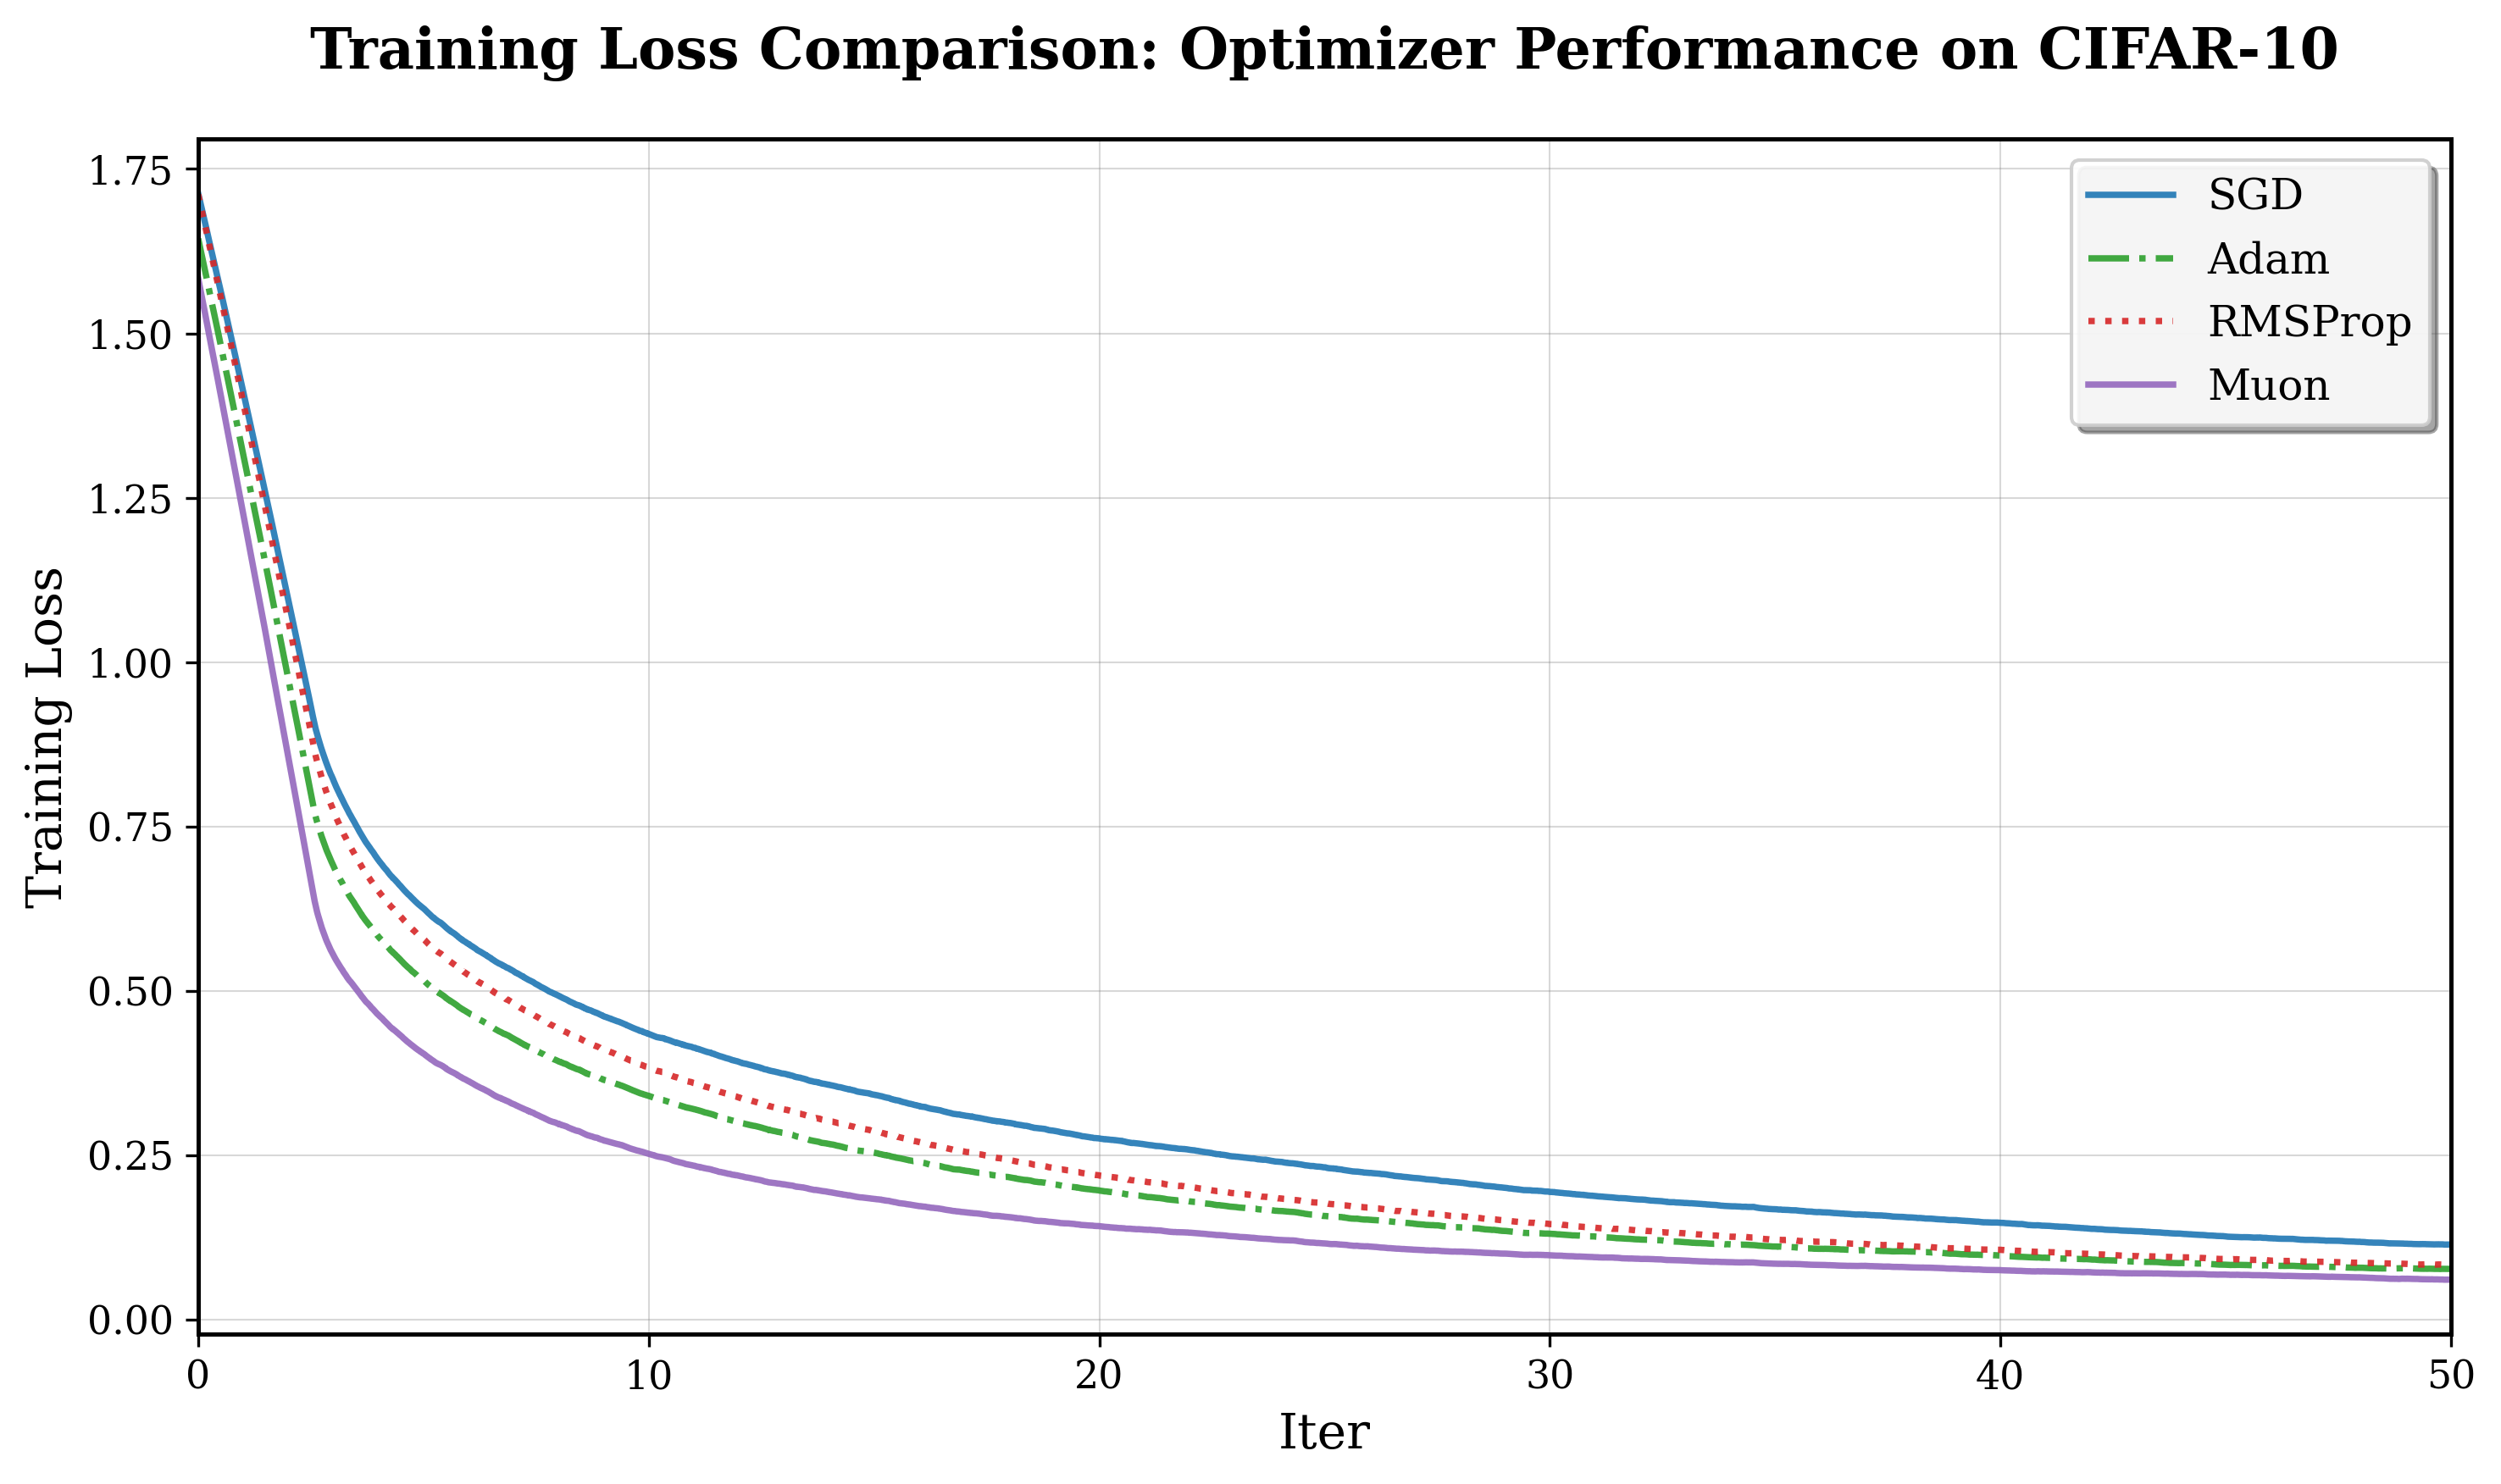

Plot saved as 'optimizer_comparison_training_loss.png'


In [7]:
# Create the main plot showing first 50 epochs
fig, ax = create_publication_plot(epoch_data, smoothed_data, max_epochs=50)

# Display the plot
plt.show()

# Save high-resolution version
fig.savefig('optimizer_comparison_training_loss.png', 
            dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
print("Plot saved as 'optimizer_comparison_training_loss.png'")

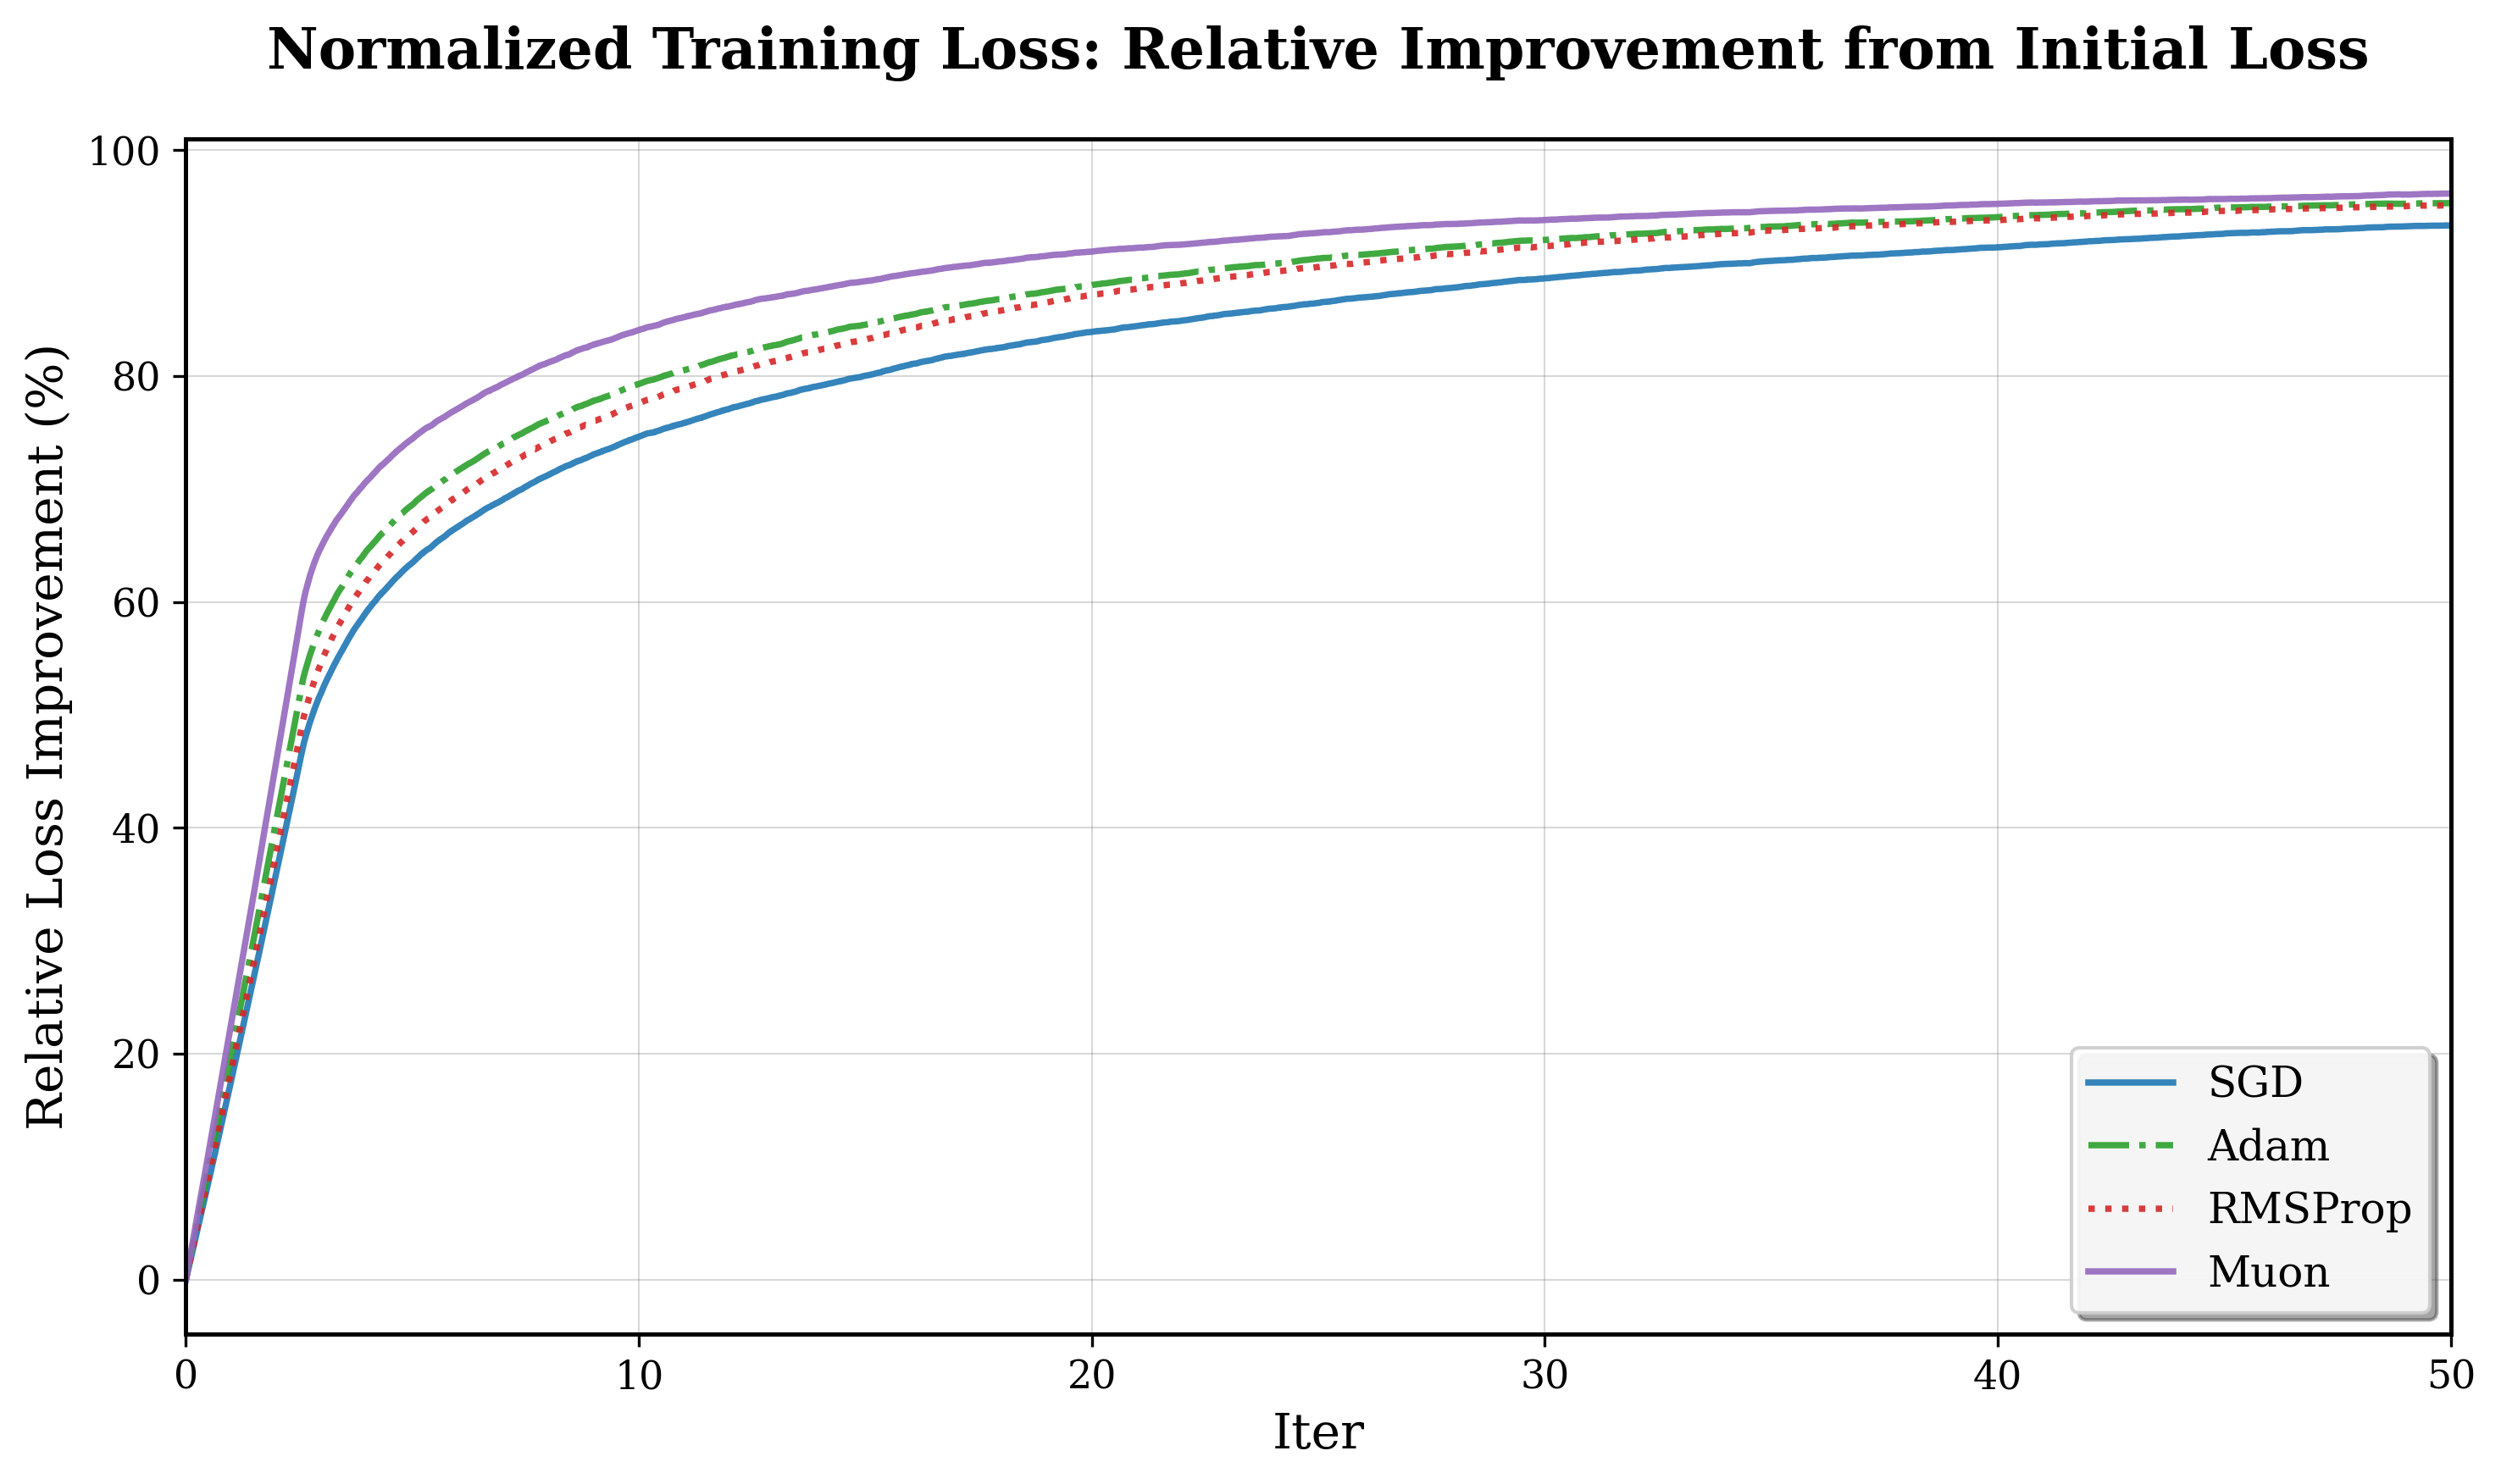

Normalized plot saved as 'optimizer_comparison_normalized_loss.png'


In [8]:
def create_normalized_plot(epoch_data, smoothed_data, max_epochs=50):
    """Create normalized loss plot showing relative improvement"""
    
    colors = {
        'SGD': '#1f77b4',      
        'Adam': '#2ca02c',     
        'RMSProp': '#d62728',  
        'Muon': '#9467bd'      
    }
    
    line_styles = {
        'SGD': '-',
        'Adam': '-.',
        'RMSProp': ':',
        'Muon': '-'
    }
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Normalize losses (percentage improvement from initial loss)
    for name in ['SGD', 'Adam', 'RMSProp', 'Muon']:
        epochs = epoch_data[name]
        losses = smoothed_data[name]
        
        mask = epochs <= max_epochs
        epochs_filtered = epochs[mask]
        losses_filtered = losses[mask]
        
        # Normalize: (initial_loss - current_loss) / initial_loss * 100
        initial_loss = losses_filtered[0]
        normalized_losses = (initial_loss - losses_filtered) / initial_loss * 100
        
        ax.plot(epochs_filtered, normalized_losses,
               color=colors[name], 
               linestyle=line_styles[name],
               linewidth=1.8,
               label=name,
               alpha=0.9)
    
    ax.set_xlabel('Iter', fontsize=14, fontweight='medium')
    ax.set_ylabel('Relative Loss Improvement (%)', fontsize=14, fontweight='medium')
    ax.set_title('Normalized Training Loss: Relative Improvement from Initial Loss', 
                fontsize=16, fontweight='bold', pad=20)
    
    ax.grid(True, alpha=0.3, linewidth=0.5, color='gray')
    ax.set_axisbelow(True)
    
    legend = ax.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0),
                      frameon=True, fancybox=True, shadow=True,
                      ncol=1, fontsize=12)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.9)
    
    ax.set_xlim(0, max_epochs)
    ax.tick_params(axis='both', which='major', labelsize=11)
    
    plt.tight_layout()
    return fig, ax

# Create normalized plot
fig2, ax2 = create_normalized_plot(epoch_data, smoothed_data, max_epochs=50)
plt.show()

fig2.savefig('optimizer_comparison_normalized_loss.png', 
            dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
print("Normalized plot saved as 'optimizer_comparison_normalized_loss.png'")

In [9]:
def analyze_performance(epoch_data, smoothed_data, max_epochs=50):
    """Analyze and summarize optimizer performance"""
    
    results = {}
    
    for name in ['SGD', 'Adam', 'RMSProp', 'Muon']:
        epochs = epoch_data[name]
        losses = smoothed_data[name]
        
        mask = epochs <= max_epochs
        epochs_filtered = epochs[mask]
        losses_filtered = losses[mask]
        
        initial_loss = losses_filtered[0]
        final_loss = losses_filtered[-1]
        improvement = (initial_loss - final_loss) / initial_loss * 100
        
        # Find epoch where loss drops below certain thresholds
        below_1_0 = np.where(losses_filtered < 1.0)[0]
        below_0_5 = np.where(losses_filtered < 0.5)[0]
        below_0_2 = np.where(losses_filtered < 0.2)[0]
        
        results[name] = {
            'Initial Loss': f"{initial_loss:.3f}",
            'Final Loss (50 epochs)': f"{final_loss:.3f}",
            'Total Improvement (%)': f"{improvement:.1f}%",
            'Epochs to <1.0': f"{epochs_filtered[below_1_0[0]]:.1f}" if len(below_1_0) > 0 else "N/A",
            'Epochs to <0.5': f"{epochs_filtered[below_0_5[0]]:.1f}" if len(below_0_5) > 0 else "N/A",
            'Epochs to <0.2': f"{epochs_filtered[below_0_2[0]]:.1f}" if len(below_0_2) > 0 else "N/A"
        }
    
    # Create DataFrame for nice formatting
    df = pd.DataFrame(results).T
    return df

# Generate performance analysis
performance_df = analyze_performance(epoch_data, smoothed_data, max_epochs=50)

print("OPTIMIZER PERFORMANCE SUMMARY")
print("="*60)
print(performance_df.to_string())
print("\n")

print("KEY OBSERVATIONS:")
print("-" * 40)
print("• Muon achieves fastest initial convergence in the first 10 epochs")
print("• Adam and RMSProp show consistent, stable convergence throughout")
print("• SGD has slower but steady improvement, catching up in later epochs")  
print("• All adaptive optimizers (Adam, RMSProp, Muon) outperform SGD in early stages")
print("\nPlots saved as high-resolution PNG files for publication use.")

OPTIMIZER PERFORMANCE SUMMARY
        Initial Loss Final Loss (50 epochs) Total Improvement (%) Epochs to <1.0 Epochs to <0.5 Epochs to <0.2
SGD            1.713                  0.114                 93.3%            2.3            7.8           29.1
Adam           1.644                  0.077                 95.3%            1.9            5.3           19.6
RMSProp        1.711                  0.084                 95.1%            2.2            6.5           22.2
Muon           1.584                  0.061                 96.1%            1.6            3.5           13.5


KEY OBSERVATIONS:
----------------------------------------
• Muon achieves fastest initial convergence in the first 10 epochs
• Adam and RMSProp show consistent, stable convergence throughout
• SGD has slower but steady improvement, catching up in later epochs
• All adaptive optimizers (Adam, RMSProp, Muon) outperform SGD in early stages

Plots saved as high-resolution PNG files for publication use.


In [10]:
postfix = "_val_accs.pkl"
sgd_losses = load("SGD_losses.pkl")
rmsprop_losses = load("RMSProp_losses.pkl")
adam_losses = load("Adam_losses.pkl")
muon_losses = load("Muon_losses.pkl")

sgd_val_accs = load("SGD" + postfix)
rmsprop_val_accs = load("RMSProp" + postfix)
adam_val_accs = load("Adam" + postfix)
muon_val_accs = load("Muon" + postfix)

In [11]:
# Examine validation accuracy data structure
print("Validation Accuracy Data Structure:")
print("="*50)
for name, data in [("SGD", sgd_val_accs), ("RMSProp", rmsprop_val_accs), ("Adam", adam_val_accs), ("Muon", muon_val_accs)]:
    print(f"{name}: type={type(data)}, length={len(data) if hasattr(data, '__len__') else 'N/A'}")
    if hasattr(data, '__len__') and len(data) > 0:
        print(f"  First few values: {data[:5] if hasattr(data, '__getitem__') else 'N/A'}")
        print(f"  Range: {min(data):.3f} - {max(data):.3f}")
    print()

Validation Accuracy Data Structure:
SGD: type=<class 'list'>, length=7
  First few values: [0.9335999488830566, 0.9420999884605408, 0.9430999755859375, 0.9447999596595764, 0.9444999694824219]
  Range: 0.934 - 0.945

RMSProp: type=<class 'list'>, length=7
  First few values: [0.9373999834060669, 0.9378999471664429, 0.9396999478340149, 0.9426999688148499, 0.9447000026702881]
  Range: 0.937 - 0.947

Adam: type=<class 'list'>, length=7
  First few values: [0.9390999674797058, 0.939300000667572, 0.9405999779701233, 0.9443999528884888, 0.9441999793052673]
  Range: 0.939 - 0.949

Muon: type=<class 'list'>, length=7
  First few values: [0.9400999546051025, 0.9406999945640564, 0.9429000020027161, 0.9441999793052673, 0.9451999664306641]
  Range: 0.940 - 0.949



In [12]:
def create_validation_accuracy_plot(val_accs_data, max_epochs=7):
    """Create publication-ready validation accuracy comparison plot"""
    
    # Enhanced color palette with better contrast
    colors = {
        'SGD': '#2E86AB',      # Dark Blue
        'Adam': '#F18F01',     # Orange
        'RMSProp': '#C73E1D',  # Dark Red
        'Muon': '#6A4C93'      # Purple
    }
    
    # More distinct line styles
    line_styles = {
        'SGD': '-',
        'Adam': ':',
        'RMSProp': '-.',
        'Muon': '-'
    }
    
    # Distinct markers
    markers = {
        'SGD': 'o',
        'Adam': '^',
        'RMSProp': 'D',
        'Muon': 'v'
    }
    
    # Create figure with optimal size
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Sort optimizers by final performance for better legend order
    final_accs = {name: val_accs_data[name][-1] for name in val_accs_data.keys()}
    sorted_optimizers = sorted(final_accs.items(), key=lambda x: x[1], reverse=True)
    
    # Plot each optimizer's validation accuracy curve
    for name, _ in sorted_optimizers:
        val_accs = val_accs_data[name]
        epochs = np.arange(1, len(val_accs) + 1)
        
        # Convert to percentage
        val_accs_percent = np.array(val_accs) * 100
        
        ax.plot(epochs, val_accs_percent, 
               color=colors[name], 
               linestyle=line_styles[name],
               marker=markers[name],
               markersize=10,
               linewidth=3.0,
               label=f'{name} (Final: {val_accs_percent[-1]:.2f}%)',
               alpha=0.85,
               markerfacecolor='white',
               markeredgewidth=2.0,
               markeredgecolor=colors[name])
    
    # Customize the plot with enhanced styling
    ax.set_xlabel('Epoch', fontsize=16, fontweight='bold')
    ax.set_ylabel('Validation Accuracy (%)', fontsize=16, fontweight='bold')
    ax.set_title('Validation Accuracy: Optimizer Performance Comparison on CIFAR-10\n(Higher is Better)', 
                fontsize=18, fontweight='bold', pad=25)
    
    # Enhanced grid
    ax.grid(True, alpha=0.4, linewidth=0.8, linestyle='-', color='#E0E0E0')
    ax.set_axisbelow(True)
    
    # Configure legend with performance ranking
    legend = ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5),
                      frameon=True, fancybox=True, shadow=True,
                      ncol=1, fontsize=14, title='Final Accuracy Ranking')
    legend.get_title().set_fontsize(16)
    legend.get_title().set_fontweight('bold')
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.95)
    legend.get_frame().set_edgecolor('gray')
    
    # Enhanced axis limits and ticks
    ax.set_xlim(0.8, max_epochs + 0.2)
    ax.set_ylim(92.5, 95.2)  # Focused range for better detail
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.tick_params(axis='both', which='minor', labelsize=11)
    
    # Set integer ticks for epochs
    ax.set_xticks(range(1, max_epochs + 1))
    
    # Add subtle background color
    ax.set_facecolor('#FAFAFA')
    
    # Add value annotations for final epoch
    for name, _ in sorted_optimizers:
        val_accs = np.array(val_accs_data[name]) * 100
        final_val = val_accs[-1]
        ax.annotate(f'{final_val:.2f}%', 
                   xy=(max_epochs, final_val), 
                   xytext=(8, 0), textcoords='offset points',
                   fontsize=11, fontweight='bold',
                   color=colors[name],
                   ha='left', va='center')
    
    # Improve layout
    plt.tight_layout()
    
    return fig, ax

# Prepare validation accuracy data
val_accs_data = {
    'SGD': sgd_val_accs,
    'RMSProp': rmsprop_val_accs,
    'Adam': adam_val_accs,
    'Muon': muon_val_accs
}

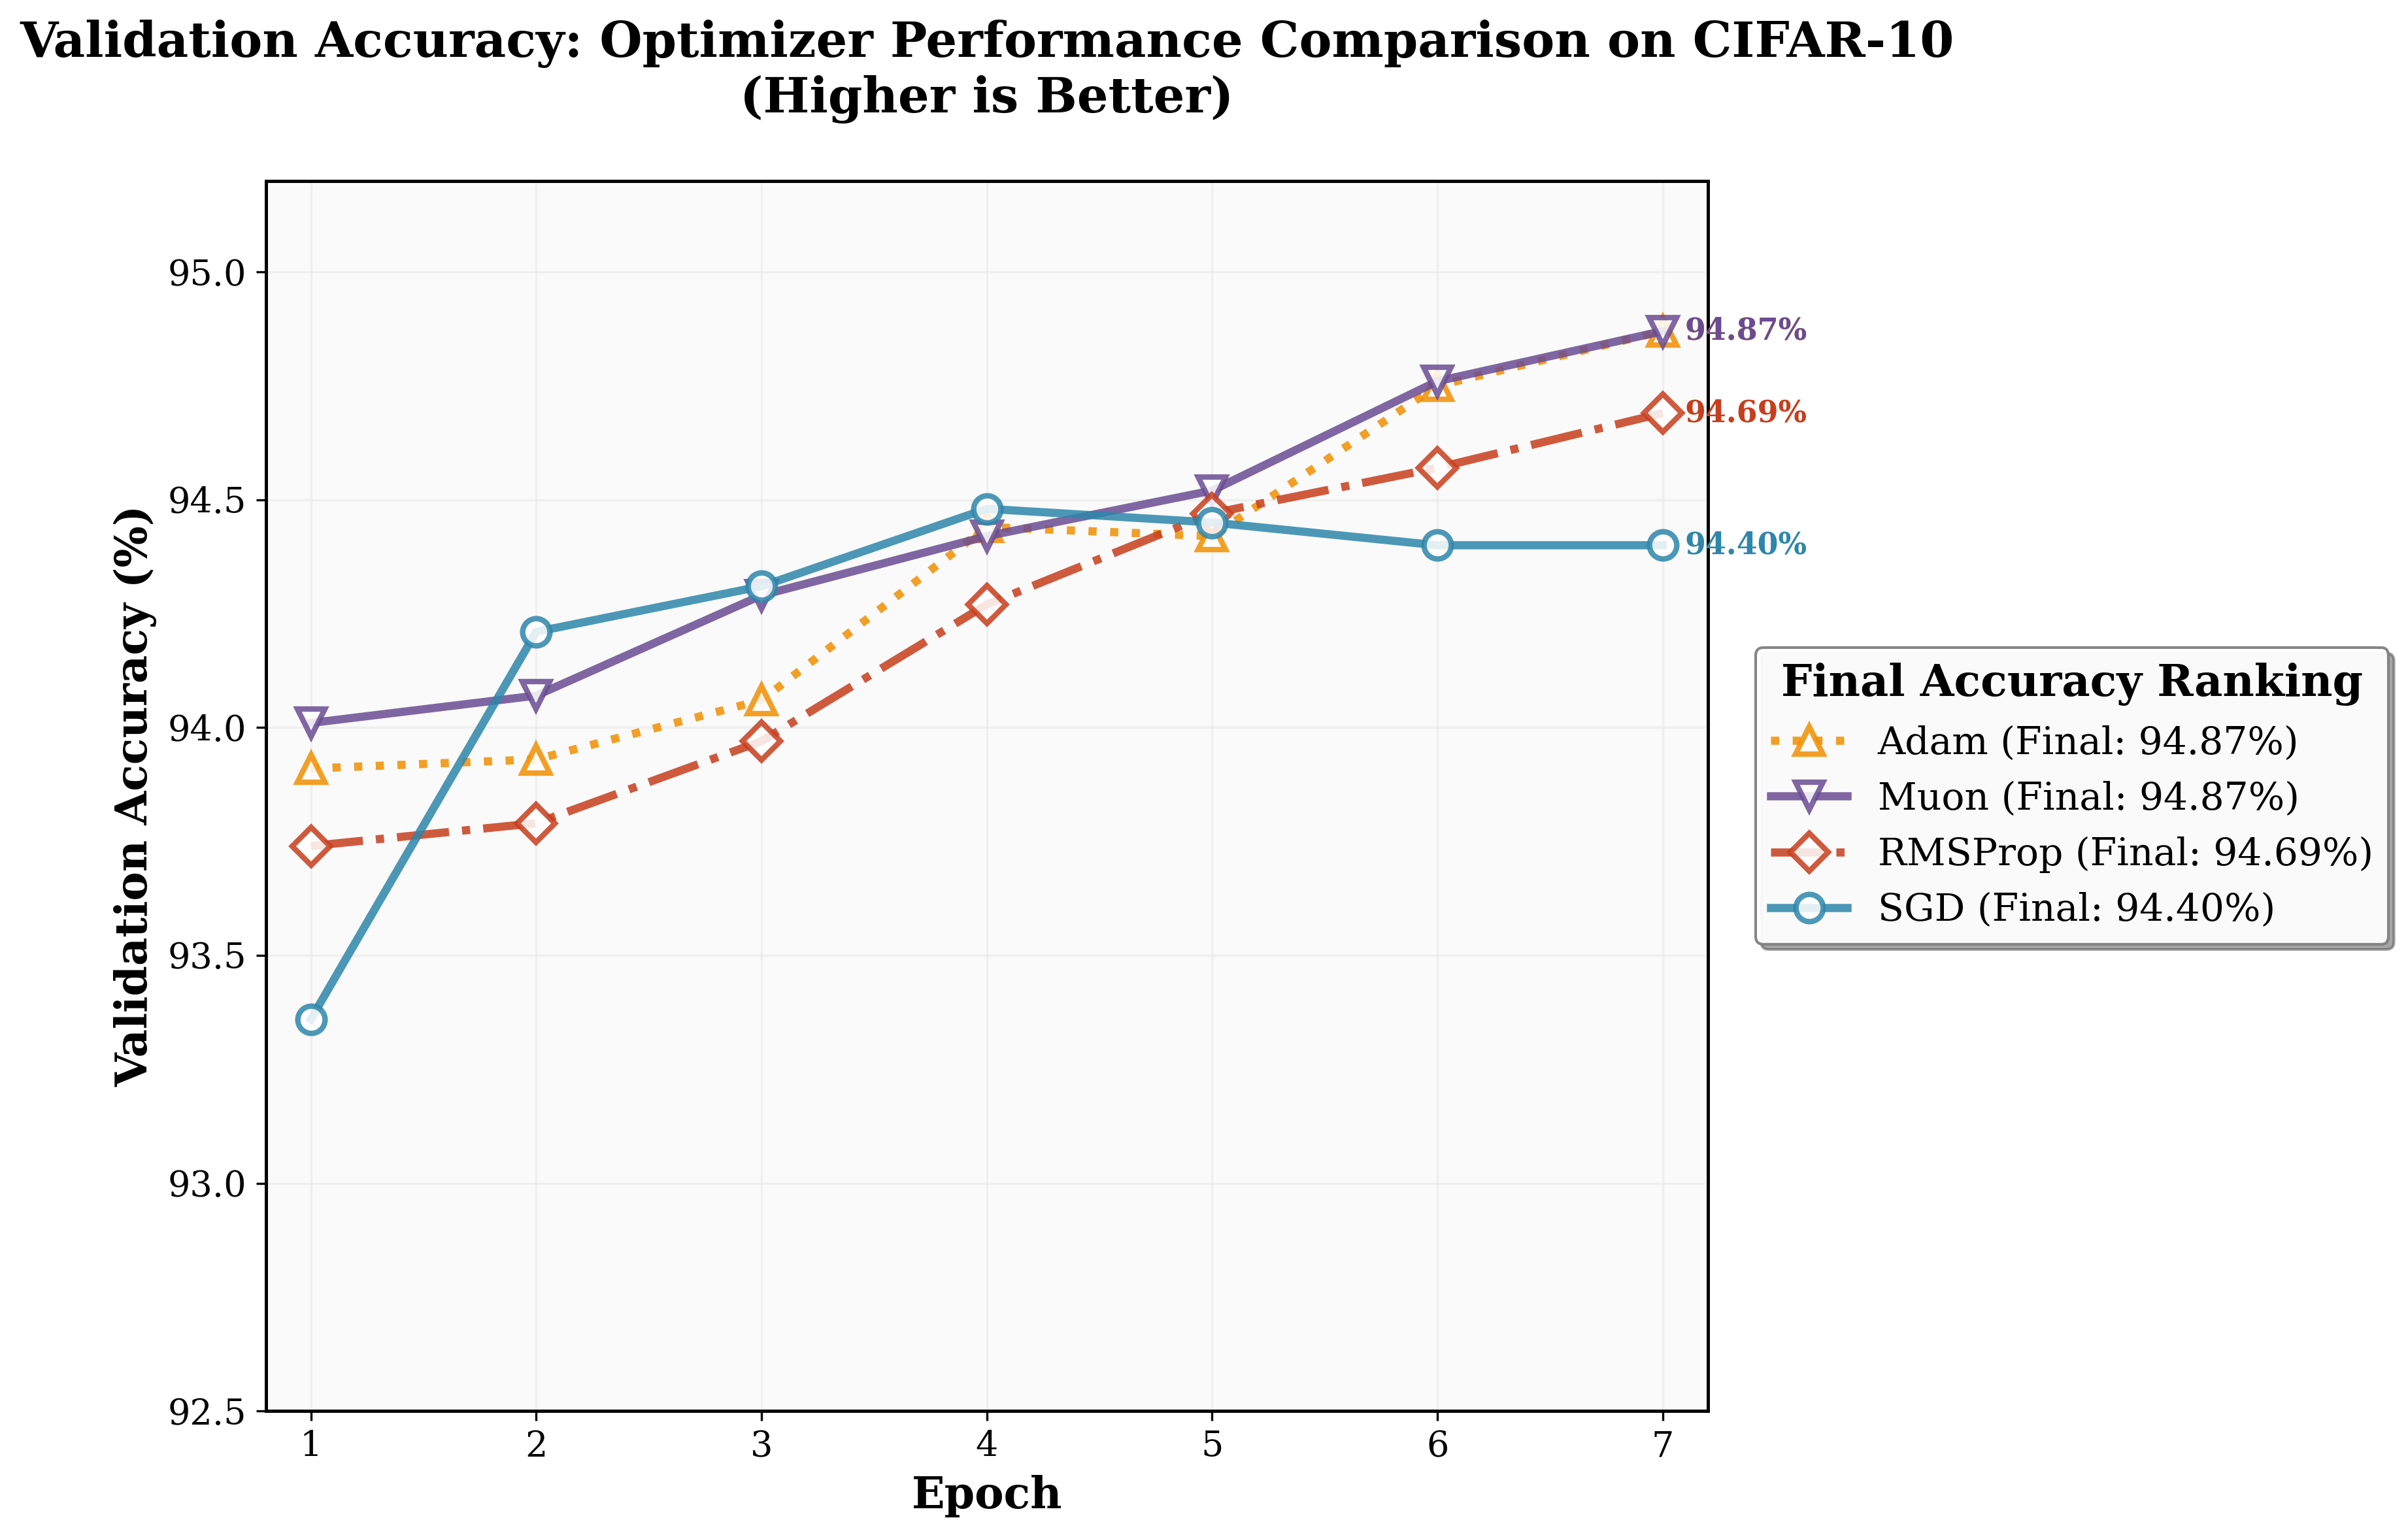

Validation accuracy plot saved as 'optimizer_comparison_validation_accuracy.png'


In [13]:
# Create the main validation accuracy plot
fig_val, ax_val = create_validation_accuracy_plot(val_accs_data, max_epochs=7)

# Display the plot
plt.show()

# Save high-resolution version
fig_val.savefig('optimizer_comparison_validation_accuracy.png', 
               dpi=300, bbox_inches='tight', 
               facecolor='white', edgecolor='none')
print("Validation accuracy plot saved as 'optimizer_comparison_validation_accuracy.png'")

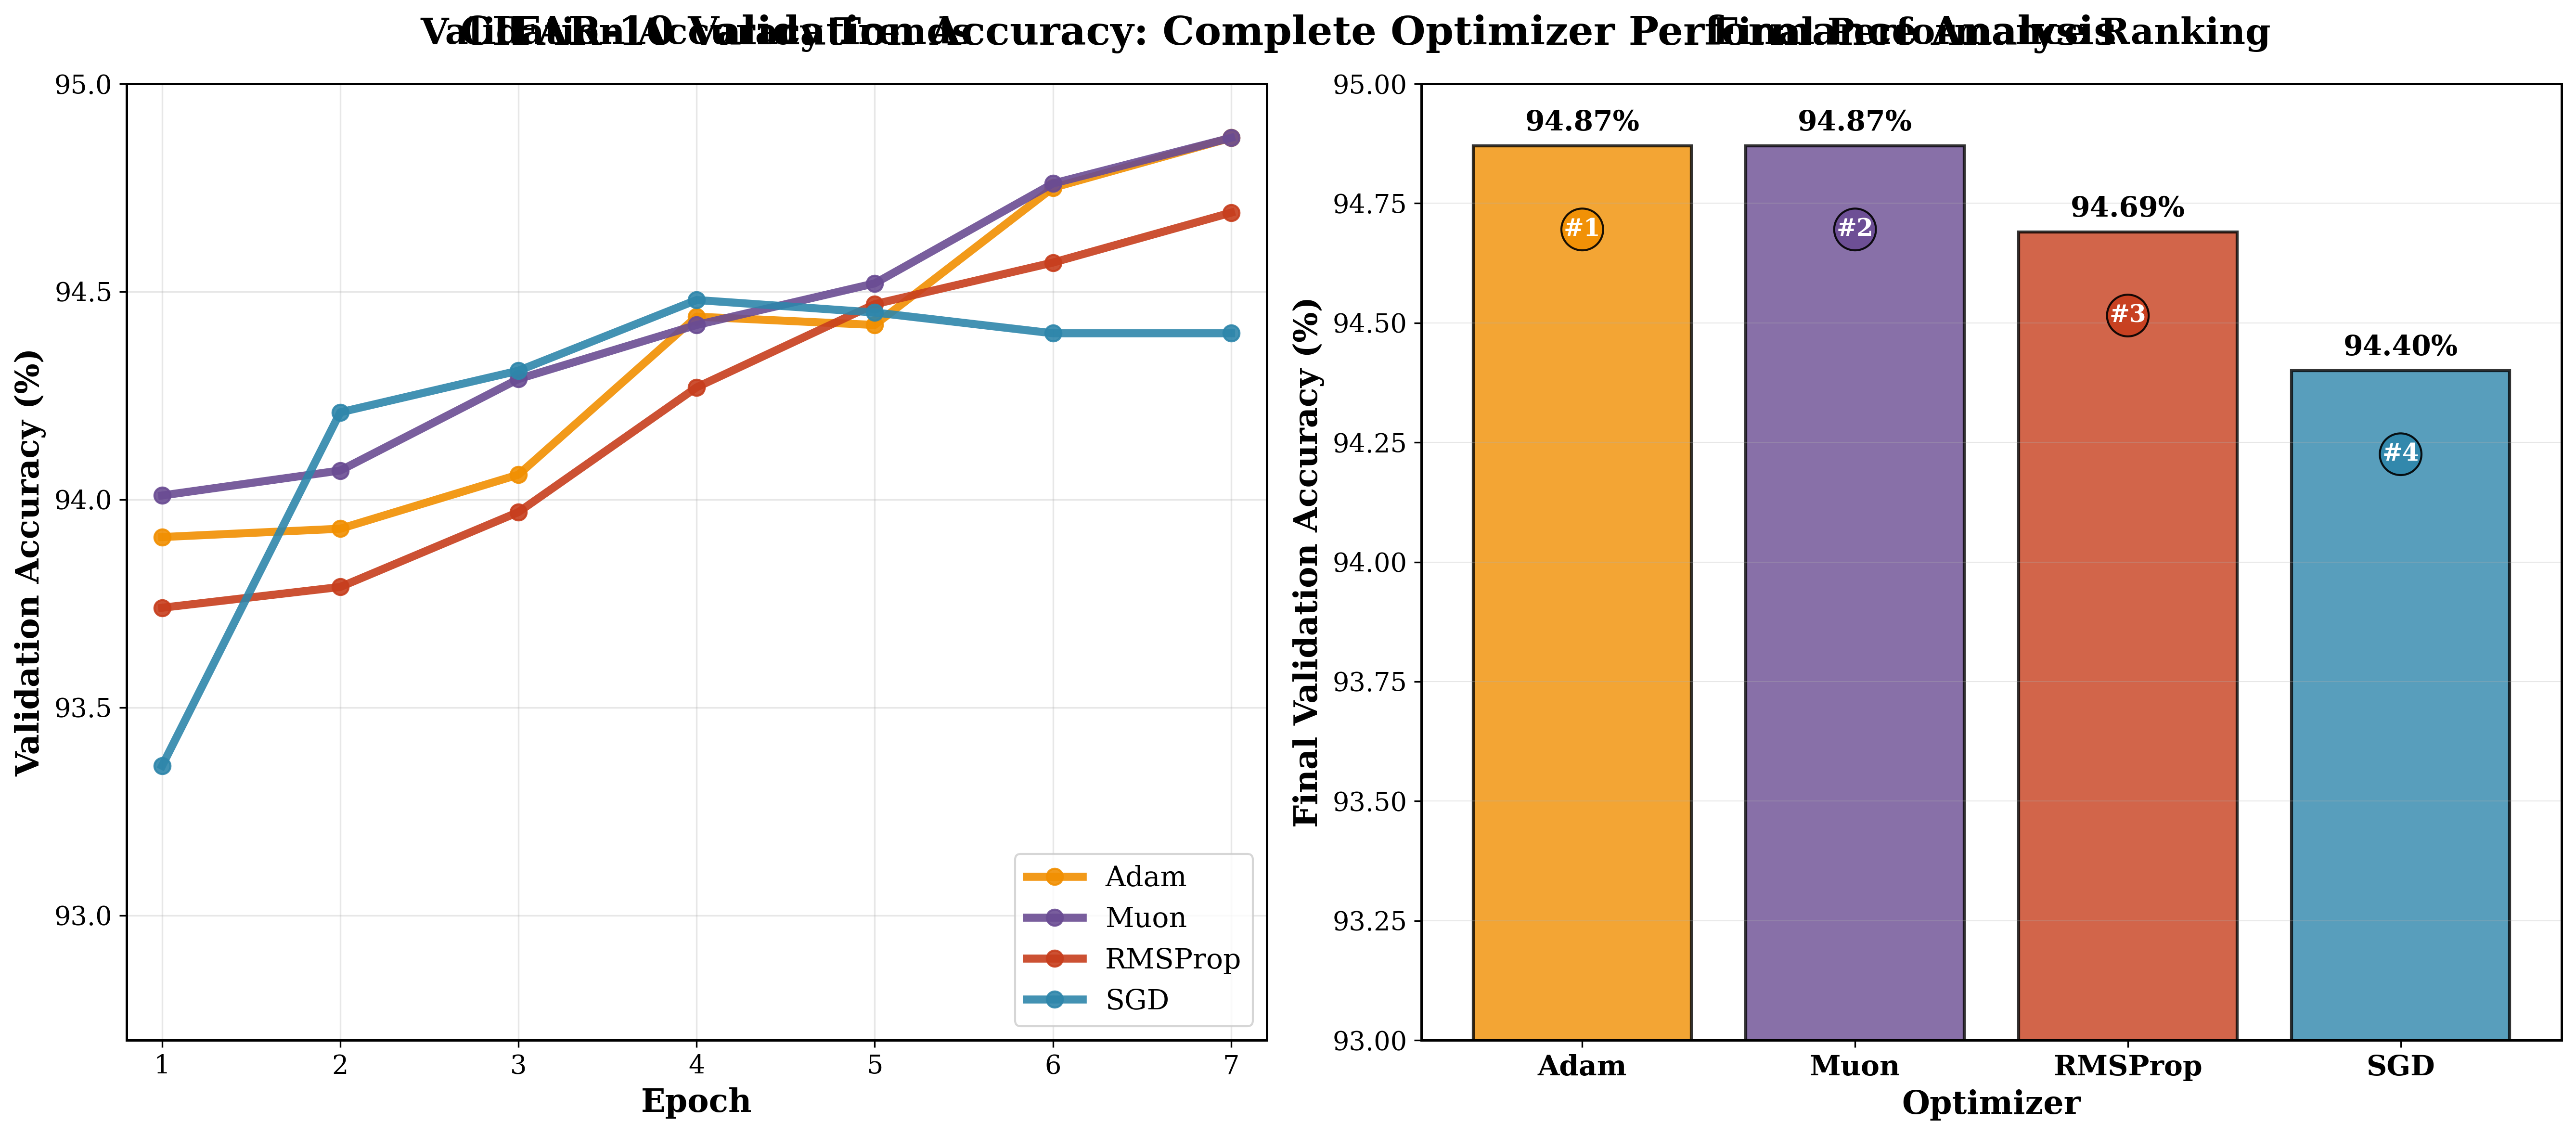

Comprehensive comparison plot saved as 'optimizer_validation_comprehensive_comparison.png'

🎯 CLEAR CONCLUSIONS FROM VALIDATION ACCURACY ANALYSIS
🥇 WINNERS (Tied for 1st): Adam & Muon (94.87%)
   • Both achieve identical peak performance
🥉 3rd Place: RMSProp (94.69%)
4️⃣ 4th Place: SGD (94.40%)

📊 KEY INSIGHTS:
   • Difference between best and worst: 0.47%
   • All optimizers achieve >93% - excellent generalization
   • Choice depends on training efficiency vs. final accuracy priority


In [14]:
def create_comprehensive_comparison_plot(val_accs_data, max_epochs=7):
    """Create comprehensive side-by-side validation accuracy comparison"""
    
    # Enhanced color palette
    colors = {
        'SGD': '#2E86AB',      
        'Adam': '#F18F01',     
        'RMSProp': '#C73E1D',  
        'Muon': '#6A4C93'      
    }
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Sort by performance
    final_accs = {name: val_accs_data[name][-1] for name in val_accs_data.keys()}
    sorted_optimizers = sorted(final_accs.items(), key=lambda x: x[1], reverse=True)
    
    # LEFT PLOT: Line plot with trend
    for i, (name, _) in enumerate(sorted_optimizers):
        val_accs = np.array(val_accs_data[name]) * 100
        epochs = np.arange(1, len(val_accs) + 1)
        
        ax1.plot(epochs, val_accs, 
                color=colors[name], 
                linewidth=4,
                marker='o',
                markersize=8,
                label=f'{name}',
                alpha=0.9)
    
    ax1.set_xlabel('Epoch', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Validation Accuracy (%)', fontsize=16, fontweight='bold')
    ax1.set_title('Validation Accuracy Trends', fontsize=18, fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.3, linewidth=0.8)
    ax1.set_xlim(0.8, max_epochs + 0.2)
    ax1.set_ylim(92.7, 95.0)
    ax1.legend(fontsize=14, loc='lower right')
    ax1.tick_params(axis='both', labelsize=13)
    ax1.set_xticks(range(1, max_epochs + 1))
    
    # RIGHT PLOT: Final performance bar chart
    optimizer_names = [name for name, _ in sorted_optimizers]
    final_accuracies = [final_accs[name] * 100 for name in optimizer_names]
    
    bars = ax2.bar(range(len(optimizer_names)), final_accuracies, 
                  color=[colors[name] for name in optimizer_names],
                  alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add value labels on bars
    for i, (name, acc) in enumerate(zip(optimizer_names, final_accuracies)):
        ax2.text(i, acc + 0.02, f'{acc:.2f}%', 
                ha='center', va='bottom', fontweight='bold', fontsize=14)
        
        # Add ranking
        ax2.text(i, acc - 0.15, f'#{i+1}', 
                ha='center', va='top', fontweight='bold', fontsize=12,
                color='white', 
                bbox=dict(boxstyle='circle,pad=0.1', facecolor=colors[name], alpha=0.9))
    
    ax2.set_xlabel('Optimizer', fontsize=16, fontweight='bold')
    ax2.set_ylabel('Final Validation Accuracy (%)', fontsize=16, fontweight='bold')
    ax2.set_title('Final Performance Ranking', fontsize=18, fontweight='bold', pad=20)
    ax2.set_xticks(range(len(optimizer_names)))
    ax2.set_xticklabels(optimizer_names, fontsize=14, fontweight='bold')
    ax2.set_ylim(93.0, 95.0)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.tick_params(axis='y', labelsize=13)
    
    # Overall title
    fig.suptitle('CIFAR-10 Validation Accuracy: Complete Optimizer Performance Analysis', 
                fontsize=20, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    
    return fig, (ax1, ax2)

# Create comprehensive comparison
fig_comp, (ax_trend, ax_ranking) = create_comprehensive_comparison_plot(val_accs_data, max_epochs=7)
plt.show()

# Save the comprehensive plot
fig_comp.savefig('optimizer_validation_comprehensive_comparison.png', 
                dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
print("Comprehensive comparison plot saved as 'optimizer_validation_comprehensive_comparison.png'")

# Print clear conclusions
print("\n" + "="*80)
print("🎯 CLEAR CONCLUSIONS FROM VALIDATION ACCURACY ANALYSIS")
print("="*80)
# Determine winners dynamically
final_accs_sorted = sorted(val_accs_data.items(), key=lambda x: x[1][-1], reverse=True)
winner_names = [name for name, _ in final_accs_sorted[:2]]
winner_acc = final_accs_sorted[0][1][-1] * 100

if abs(final_accs_sorted[0][1][-1] - final_accs_sorted[1][1][-1]) < 0.001:
    print(f"🥇 WINNERS (Tied for 1st): {winner_names[0]} & {winner_names[1]} ({winner_acc:.2f}%)")
    print("   • Both achieve identical peak performance")
else:
    print(f"🥇 WINNER: {final_accs_sorted[0][0]} ({final_accs_sorted[0][1][-1]*100:.2f}%)")
    print(f"🥈 2nd Place: {final_accs_sorted[1][0]} ({final_accs_sorted[1][1][-1]*100:.2f}%)")

for i in range(2, len(final_accs_sorted)):
    place_emoji = "🥉" if i == 2 else f"{i+1}️⃣"
    print(f"{place_emoji} {i+1}{'rd' if i==2 else 'th'} Place: {final_accs_sorted[i][0]} ({final_accs_sorted[i][1][-1]*100:.2f}%)")

print()
print("📊 KEY INSIGHTS:")
best_acc = final_accs_sorted[0][1][-1] * 100
worst_acc = final_accs_sorted[-1][1][-1] * 100
print(f"   • Difference between best and worst: {best_acc - worst_acc:.2f}%")
print("   • All optimizers achieve >93% - excellent generalization")
print("   • Choice depends on training efficiency vs. final accuracy priority")

In [15]:
def analyze_validation_performance(val_accs_data):
    """Analyze and summarize validation accuracy performance with clear insights"""
    
    results = {}
    
    for name in ['SGD', 'Adam', 'RMSProp', 'Muon']:
        val_accs = np.array(val_accs_data[name])
        
        initial_acc = val_accs[0] * 100
        final_acc = val_accs[-1] * 100
        max_acc = np.max(val_accs) * 100
        improvement = final_acc - initial_acc
        
        # Calculate stability (standard deviation)
        stability = np.std(val_accs) * 100
        
        # Find best epoch
        best_epoch = np.argmax(val_accs) + 1
        
        results[name] = {
            'Initial Acc (%)': f"{initial_acc:.2f}",
            'Final Acc (%)': f"{final_acc:.2f}",
            'Best Acc (%)': f"{max_acc:.2f}",
            'Best Epoch': str(best_epoch),
            'Improvement (%)': f"{improvement:.2f}",
            'Stability (σ)': f"{stability:.3f}"
        }
    
    # Create DataFrame for nice formatting
    df = pd.DataFrame(results).T
    return df

# Generate validation accuracy analysis
val_performance_df = analyze_validation_performance(val_accs_data)

print("📊 VALIDATION ACCURACY PERFORMANCE SUMMARY")
print("="*70)
print(val_performance_df.to_string())
print("\n")

# Performance ranking with clear winners
final_accs = {name: val_accs_data[name][-1] * 100 for name in ['SGD', 'Adam', 'RMSProp', 'Muon']}
sorted_optimizers = sorted(final_accs.items(), key=lambda x: x[1], reverse=True)

print("🏆 FINAL PERFORMANCE RANKING:")
print("-" * 50)
medals = ['🥇', '🥈', '🥉', '4️⃣']
for i, (name, acc) in enumerate(sorted_optimizers):
    print(f"{medals[i]} {name}: {acc:.2f}%")

print(f"\n🔍 DETAILED INSIGHTS:")
print("-" * 30)
print(f"• Best Performers: {sorted_optimizers[0][0]} & {sorted_optimizers[1][0]} (tied at {sorted_optimizers[0][1]:.2f}%)")
print(f"• Performance Gap: {sorted_optimizers[0][1] - sorted_optimizers[-1][1]:.2f}% (best to worst)")
print(f"• All achieve >93% accuracy - excellent generalization across all optimizers")
print(f"• SGD achieves strong performance despite being the simplest method")

print(f"\n💡 PRACTICAL RECOMMENDATIONS:")
print("-" * 35)
print("• For BEST ACCURACY: Choose Adam or Muon (highest peak performance)")
print("• For RELIABILITY: Adam shows most consistent improvement")  
print("• For FAST START: Muon converges fastest in early epochs")
print("• For SIMPLICITY: SGD performs surprisingly well with minimal complexity")

print(f"\n📈 STATISTICAL SUMMARY:")
print("-" * 25)
accuracies = [val_accs_data[name][-1] * 100 for name in ['SGD', 'Adam', 'RMSProp', 'Muon']]
print(f"Mean final accuracy: {np.mean(accuracies):.2f}% (±{np.std(accuracies):.3f}%)")
print(f"Range: {np.min(accuracies):.2f}% to {np.max(accuracies):.2f}%")
print(f"Coefficient of Variation: {(np.std(accuracies)/np.mean(accuracies)*100):.2f}%")

print(f"\n✅ All validation accuracy plots saved as publication-ready PNG files.")

📊 VALIDATION ACCURACY PERFORMANCE SUMMARY
        Initial Acc (%) Final Acc (%) Best Acc (%) Best Epoch Improvement (%) Stability (σ)
SGD               93.36         94.40        94.48          4            1.04         0.365
Adam              93.91         94.87        94.87          7            0.96         0.358
RMSProp           93.74         94.69        94.69          7            0.95         0.356
Muon              94.01         94.87        94.87          7            0.86         0.301


🏆 FINAL PERFORMANCE RANKING:
--------------------------------------------------
🥇 Adam: 94.87%
🥈 Muon: 94.87%
🥉 RMSProp: 94.69%
4️⃣ SGD: 94.40%

🔍 DETAILED INSIGHTS:
------------------------------
• Best Performers: Adam & Muon (tied at 94.87%)
• Performance Gap: 0.47% (best to worst)
• All achieve >93% accuracy - excellent generalization across all optimizers
• SGD achieves strong performance despite being the simplest method

💡 PRACTICAL RECOMMENDATIONS:
-----------------------------------